In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    f1_score,
    make_scorer
)
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold

In [2]:
enrichment = pd.read_csv(r"C:\Users\Семён\Desktop\test task - data scientist\infutor_enrichment_dataset.csv")
zipcode = pd.read_csv(r"C:\Users\Семён\Desktop\test task - data scientist\zip_code_dataset.csv")
leads = pd.read_csv(r"C:\Users\Семён\Desktop\test task - data scientist\leads_dataset.csv")
df = leads.merge(enrichment, how='left', on='HASHED_PHONE_NUMBER')
df = df.merge(zipcode, how='left', on='ZIP_CODE')
df['id'] = df['HASHED_PHONE_NUMBER'].astype(str) + ';' + \
           df['IS_APPOINTMENT_SET'].astype(str) + ';' + \
           df['LEAD_CREATED_AT_UTC'].astype(str)
df = df.drop_duplicates(subset=['id'])
df.shape
reserve=df.copy()

In [3]:
a = df.columns
print(", ".join(a))

HASHED_PHONE_NUMBER, IS_APPOINTMENT_SET, LEAD_CREATED_AT_UTC, ZIP_CODE, CITY, STATE, COUNTY, EMAIL_DOMAIN, OPERATINGSYSTEMCLASS, OPERATINGSYSTEMNAME, AGENTLANGUAGECODE, AGENTNAME, AGENTVERSIONMAJOR, DEVICEBRAND, DEVICEFIRMWAREVERSION, DEVICENAME, DEVICEVERSION, FACEBOOKDEVICECLASS, LAYOUTENGINENAME, NETWORKTYPE, OPERATINGSYSTEMVERSIONMAJOR, WEBVIEWAPPNAME, Unnamed: 0, MATCHLEVEL, ATTRIBUTES_CONNEXSEGMENTATION_CT_HOMEIMPROVE12_ANY, ATTRIBUTES_CONNEXSEGMENTATION_CT_HOMEREMODEL12_ANY, ATTRIBUTES_COREDEMOGRAPHICS_DOB, ATTRIBUTES_COREDEMOGRAPHICS_GENDER, ATTRIBUTES_COREDEMOGRAPHICS_MARRIEDCD, ATTRIBUTES_COREDEMOGRAPHICS_WEALTHSCR, ATTRIBUTES_COREDEMOGRAPHICS_HOMEOWNERCD, ATTRIBUTES_COREDEMOGRAPHICS_EHI, ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_FIREPLCD, ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_POOL, ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_CREDITCARD, ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_HHNBRSR, ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_YRBLD, ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_LOR, ATTRIBUTES_SUPPLEMENTALDEMO

In [4]:
def analyze_column(df, col):
    print("=" * 60)
    print(f"Column: {col}")
    print(f"Dtype: {df[col].dtype}")
    print(f"Missing values: {df[col].isnull().sum()}")
    print(f"Unique values: {df[col].nunique(dropna=True)}")

    examples = df[col].dropna().unique()
    print(f"All unique values: {examples}")
    

    print("Top-5 most frequent values:")
    value_counts = df[col].value_counts(dropna=True).head(5)
    for val, count in value_counts.items():
        print(f"  {repr(val)}: {count}")

for col in df.columns:
    analyze_column(df, col)

Column: HASHED_PHONE_NUMBER
Dtype: object
Missing values: 0
Unique values: 276269
All unique values: ['16bc446a779996bf3007065819f1dd4692a17d14'
 '6d30f0d0f87d39f8c178e3750072eef79bb9d7a0'
 '9de207ef32d3696829ae369c2a9a4500cd36ec43' ...
 '85580be57f0c2e3785ffe5b6187441487915513b'
 '8e7eed2ca3dd2e5a0f27fb3288e0157471a5f81b'
 'f1864c915f0cdf097a794f50a027f84af31f79b2']
Top-5 most frequent values:
  '52dc1f49f405383db66d0f3f33a0dd6449d2e6de': 801
  'cd2bab79e874cace82d4ba36e4c5a84bb76826bc': 227
  '6e317ac9c24576beaeb44321d4d85366114098c9': 167
  'd1a2ada48a7171c10e963e6c6a69fe7331d6ba21': 97
  '45b4f5de0dd881af43281854825b7a9d129bca42': 77
Column: IS_APPOINTMENT_SET
Dtype: object
Missing values: 3089
Unique values: 2
All unique values: [True False]
Top-5 most frequent values:
  False: 236323
  True: 48387
Column: LEAD_CREATED_AT_UTC
Dtype: object
Missing values: 3089
Unique values: 282461
All unique values: ['2023-07-18T15:11:55Z' '2022-09-19T18:37:21Z' '2022-11-09T21:38:10Z' ...
 '2023-

All unique values: ['114' '605' '105' '102' '116' '16' '108' '2' '110' '104' '261' '5' '15'
 '115' '117' '99' '294' '297' '101' '106' '109' '258' '112' '276' '98'
 '230' '113' '103' '111' '305' '118' '96' '267' '97' '300' '290' '17'
 '100' '279' '107' '270' '83' '241' '289' '22' '250' '303' '296' '14' '20'
 '302' '11' '298' '234' '255' '81' '293' '12' '283' '13' '245' '251' '299'
 '95' '244' '74' '306' '275' '94' '86' '264' '272' '87' '18' '92' '181'
 '223' '295' '73' '80' '288' '8614' '93' '603' '281' '291' '8612' '90'
 '292' '10' '91' '85' '282' '229' '6' '79' '257' '89' '243' '249' '19'
 '280' '7' '285' '247' '263' '8611' '233' '301' '228' '161' 'iOS_1' '277'
 '260' '274' '265' '262' '8613' '287' '273' '254' '242' '21' '248' '239'
 '253' '278' '4' '52' '237' '197' '236' '62' '269' '218' '271' '1' '88'
 '240' '182' '84' '235' '8615' '77' '252' '64' '66' '46' 'iOS' '266'
 'd8a21c6' '238' '221' '70' '220' '604' '219' '304' '78' '225' '224' 'v6'
 '259' '58' '76' '232' '23' '71' '286' '1

All unique values: ['Unknown' 'Wifi' '2G' '4G' 'Mobile' '3G' 'Channel']
Top-5 most frequent values:
  'Unknown': 274512
  'Wifi': 8034
  '4G': 917
  '2G': 683
  'Mobile': 547
Column: OPERATINGSYSTEMVERSIONMAJOR
Dtype: object
Missing values: 3103
Unique values: 67
All unique values: ['13' '15' '12' '16' '9' '>=10.15' '10' '??' '10.15' '>=10' '11' '6' '14'
 '100' '17' '110' '7' '8' '10.12' '101' '108' '5' '107' '103' '10.13'
 '116' '10.14' '104' 'Vista' '112' '4' '114' '117' '97' '84' '77' '98'
 '106' '93' '10.11' '88' '102' '105' '99' '109' '111' '90' '113' '115'
 '10.10' 'XP' '91' '96' '10.9' '89' '86' '69' '76' '92' '81' '3' '10.16'
 '75' '65' '118' 'Hacker' '94']
Top-5 most frequent values:
  '16': 80099
  '15': 62258
  '12': 32967
  '13': 24608
  '??': 16883
Column: WEBVIEWAPPNAME
Dtype: object
Missing values: 3103
Unique values: 231
All unique values: ['Newsbreak' 'Facebook App for iOS' 'Facebook App for Android' 'Unknown'
 'Instagram' 'Unknown Webview App' 'DuckDuckGo' 'Google Sea

  195209.0: 389
  195510.0: 386
  195608.0: 379
  195709.0: 377
  195409.0: 373
Column: ATTRIBUTES_COREDEMOGRAPHICS_GENDER
Dtype: object
Missing values: 109055
Unique values: 2
All unique values: ['M' 'F']
Top-5 most frequent values:
  'F': 92114
  'M': 86630
Column: ATTRIBUTES_COREDEMOGRAPHICS_MARRIEDCD
Dtype: object
Missing values: 159717
Unique values: 2
All unique values: ['S' 'M']
Top-5 most frequent values:
  'M': 93946
  'S': 34136
Column: ATTRIBUTES_COREDEMOGRAPHICS_WEALTHSCR
Dtype: object
Missing values: 148324
Unique values: 13
All unique values: ['B' 'F' 'A' 'J' 'H' 'I' 'E' 'M' 'D' 'L' 'G' 'C' 'K']
Top-5 most frequent values:
  'H': 15559
  'K': 14735
  'I': 14639
  'A': 14477
  'M': 13605
Column: ATTRIBUTES_COREDEMOGRAPHICS_HOMEOWNERCD
Dtype: object
Missing values: 149723
Unique values: 5
All unique values: ['H' 'O' 'U' 'R' 'P']
Top-5 most frequent values:
  'H': 118461
  'O': 9071
  'R': 6195
  'U': 2843
  'P': 1506
Column: ATTRIBUTES_COREDEMOGRAPHICS_EHI
Dtype: object
Mis

All unique values: ['Y']
Top-5 most frequent values:
  'Y': 28207
Column: ATTRIBUTES_CONNEXSEGMENTATION_CT_MEDIA_HEAVYUSAGE_MAGAZINE
Dtype: object
Missing values: 248867
Unique values: 1
All unique values: ['Y']
Top-5 most frequent values:
  'Y': 38932
Column: ATTRIBUTES_CONNEXSEGMENTATION_CT_MEDIA_HEAVYUSAGE_NEWSPAPER
Dtype: object
Missing values: 264897
Unique values: 1
All unique values: ['Y']
Top-5 most frequent values:
  'Y': 22902
Column: ATTRIBUTES_CONNEXSEGMENTATION_CT_MEDIA_HEAVYUSAGE_RADIO
Dtype: object
Missing values: 254575
Unique values: 1
All unique values: ['Y']
Top-5 most frequent values:
  'Y': 33224
Column: ATTRIBUTES_CONNEXSEGMENTATION_CT_MEDIA_HEAVYUSAGE_TV
Dtype: object
Missing values: 265557
Unique values: 1
All unique values: ['Y']
Top-5 most frequent values:
  'Y': 22242
Column: Alchemist
Dtype: float64
Missing values: 3125
Unique values: 8957
All unique values: [ 2803. 14653.  1008. ... 18502. 15211.  3270.]
Top-5 most frequent values:
  0.0: 648
  19442.0: 460

All unique values: [ 694.  862.  687. ... 2354. 1997.  366.]
Top-5 most frequent values:
  597.0: 1307
  562.0: 1149
  657.0: 1052
  688.0: 948
  690.0: 926
Column: Crystal Maiden
Dtype: float64
Missing values: 3125
Unique values: 1399
All unique values: [ 611.  667.  504. ... 1713. 1633. 1795.]
Top-5 most frequent values:
  356.0: 1881
  357.0: 1770
  358.0: 1698
  352.0: 1390
  355.0: 1390
Column: Dark Seer
Dtype: float64
Missing values: 3125
Unique values: 82
All unique values: [5.6 5.7 5.2 5.  5.4 5.8 6.5 7.4 8.8 5.5 6.  6.1 5.9 6.3 8.  6.6 6.8 4.4
 6.2 7.9 3.2 3.8 7.6 6.9 8.6 6.4 6.7 7.7 4.6 4.5 4.8 7.3 8.5 5.3 5.1 8.4
 7.5 7.2 7.8 9.4 7.  7.1 8.2 4.3 4.9 4.7 4.2 3.7 8.7 9.9 9.5 8.1 3.9 0.
 8.9 3.5 3.3 4.  8.3 3.1 2.5 3.4 9.2 2.9 4.1 2.4 2.8 9.  2.6 3.6 9.1 2.3
 3.  1.8 9.3 9.8 2.7 1.4 9.6 2.2 9.7 2. ]
Top-5 most frequent values:
  5.8: 18145
  5.9: 17946
  5.7: 17342
  6.0: 16712
  6.1: 15973
Column: Dazzle
Dtype: float64
Missing values: 3125
Unique values: 21
All unique values: 

In [5]:
# Remove values occurring in less than X% of cases,
# to avoid class imbalance or perfect separation

target_columns = ['STATE', 'EMAIL_DOMAIN', 'OPERATINGSYSTEMCLASS','OPERATINGSYSTEMNAME',
                  'AGENTLANGUAGECODE', 'AGENTNAME','AGENTVERSIONMAJOR', 'DEVICEBRAND',
                 'DEVICEFIRMWAREVERSION', 'DEVICENAME' ,'DEVICEVERSION',
'FACEBOOKDEVICECLASS','LAYOUTENGINENAME','NETWORKTYPE',
'OPERATINGSYSTEMVERSIONMAJOR','WEBVIEWAPPNAME','MATCHLEVEL']
threshold = 0.1
row_count = len(df)

for col in target_columns:
    value_counts = df[col].value_counts(normalize=True)
    frequent_values = value_counts[value_counts >= threshold].index
    df[col] = df[col].apply(lambda x: x if x in frequent_values else np.nan)

# Logistic Regression

Index(['IS_APPOINTMENT_SET', 'STATE', 'EMAIL_DOMAIN', 'OPERATINGSYSTEMCLASS',
       'OPERATINGSYSTEMNAME', 'AGENTLANGUAGECODE', 'AGENTNAME',
       'AGENTVERSIONMAJOR', 'DEVICEBRAND', 'DEVICEFIRMWAREVERSION',
       'DEVICENAME', 'DEVICEVERSION', 'FACEBOOKDEVICECLASS',
       'LAYOUTENGINENAME', 'NETWORKTYPE', 'OPERATINGSYSTEMVERSIONMAJOR',
       'WEBVIEWAPPNAME', 'MATCHLEVEL'],
      dtype='object')
['STATE', 'EMAIL_DOMAIN', 'OPERATINGSYSTEMCLASS', 'OPERATINGSYSTEMNAME', 'AGENTLANGUAGECODE', 'AGENTNAME', 'AGENTVERSIONMAJOR', 'DEVICEBRAND', 'DEVICEFIRMWAREVERSION', 'DEVICENAME', 'DEVICEVERSION', 'FACEBOOKDEVICECLASS', 'LAYOUTENGINENAME', 'NETWORKTYPE', 'OPERATINGSYSTEMVERSIONMAJOR', 'WEBVIEWAPPNAME', 'MATCHLEVEL']
[]


C:\Users\Семён\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.51      0.64     70897
           1       0.19      0.55      0.28     14516

    accuracy                           0.52     85413
   macro avg       0.52      0.53      0.46     85413
weighted avg       0.74      0.52      0.58     85413

Confusion Matrix:

[[36252 34645]
 [ 6523  7993]]
Threshold for Best F1-score: 0.455
Best F1-score: 0.293

📋 Classification Report (с оптимальным порогом):
              precision    recall  f1-score   support

           0       0.86      0.16      0.27     70897
           1       0.18      0.88      0.29     14516

    accuracy                           0.28     85413
   macro avg       0.52      0.52      0.28     85413
weighted avg       0.75      0.28      0.27     85413

📊 Confusion Matrix:
[[11359 59538]
 [ 1795 12721]]


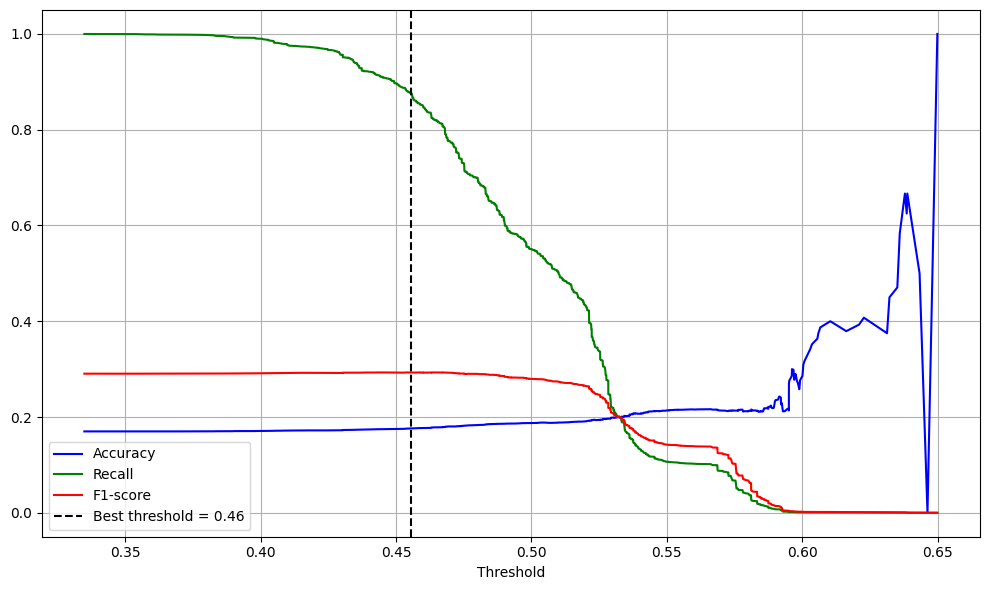

In [6]:
df_clean = df.dropna(subset=['IS_APPOINTMENT_SET']).copy()
df_clean['IS_APPOINTMENT_SET'] = df_clean['IS_APPOINTMENT_SET'].astype(int)
use_cols =  [
'IS_APPOINTMENT_SET', 
      'STATE', 'EMAIL_DOMAIN', 'OPERATINGSYSTEMCLASS','OPERATINGSYSTEMNAME',
                  'AGENTLANGUAGECODE', 'AGENTNAME','AGENTVERSIONMAJOR', 'DEVICEBRAND',
                 'DEVICEFIRMWAREVERSION', 'DEVICENAME' ,'DEVICEVERSION',
'FACEBOOKDEVICECLASS','LAYOUTENGINENAME','NETWORKTYPE',
'OPERATINGSYSTEMVERSIONMAJOR','WEBVIEWAPPNAME','MATCHLEVEL']

df_small = df_clean[use_cols].copy()
df_small = df_small.copy()
df_small = df_small[df_small['IS_APPOINTMENT_SET'].notnull()]
print(df_small.columns)
y = df_small['IS_APPOINTMENT_SET'].astype(int)
X = df_small.drop(columns=['IS_APPOINTMENT_SET'])
categorical_cols = ['STATE', 'EMAIL_DOMAIN', 'OPERATINGSYSTEMCLASS','OPERATINGSYSTEMNAME',
                  'AGENTLANGUAGECODE', 'AGENTNAME','AGENTVERSIONMAJOR', 'DEVICEBRAND',
                 'DEVICEFIRMWAREVERSION', 'DEVICENAME' ,'DEVICEVERSION',
'FACEBOOKDEVICECLASS','LAYOUTENGINENAME','NETWORKTYPE',
'OPERATINGSYSTEMVERSIONMAJOR','WEBVIEWAPPNAME','MATCHLEVEL']
print(categorical_cols)
# numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = []
print(numerical_cols)

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# cat_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
# ])
cat_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True, dtype=int))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_cols),
        ('cat', cat_transformer, categorical_cols)
    ]
)



model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        max_iter=100,
         fit_intercept=True,
        solver='lbfgs',
        multi_class='multinomial',
        random_state=42
    ))
])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


y_proba = model.predict_proba(X_test)[:, 1] 
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6) 
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
print(f"Threshold for Best F1-score: {best_threshold:.3f}")
print(f"Best F1-score: {best_f1:.3f}")


y_pred_optimal = (y_proba >= best_threshold).astype(int)
print("\n📋 Classification Report (с оптимальным порогом):")
print(classification_report(y_test, y_pred_optimal))
print("📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_optimal))


plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[1:], label='Accuracy', color='blue')
plt.plot(thresholds, recall[1:], label='Recall', color='green')
plt.plot(thresholds, f1_scores[1:], label='F1-score', color='red')
plt.axvline(x=best_threshold, color='black', linestyle='--', label=f'Best threshold = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:

# model = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', LogisticRegression(random_state=42))
# ])

# param_grid = {
#     'classifier__C': [0.1, 1.0, 10.0],
#     'classifier__solver': ['lbfgs', 'newton-cg', 'saga'],
#     'classifier__max_iter': [100, 300, 1000]
# }

# scorer = make_scorer(f1_score, average='macro') 

# search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     scoring=scorer,
#     cv=5,               
#     verbose=2,
#     n_jobs=-1           
# )

# search.fit(X_train, y_train)

# print("Best params:")
# print(search.best_params_)
# print("Best F1-score:")
# print(search.best_score_)


In [8]:
X_train_transformed = model.named_steps['preprocessor'].transform(X_train)
print(f"Unique variables: {X_train_transformed.shape[1]}")

Unique variables: 50


# LighGBM

[LightGBM] [Info] Number of positive: 33871, number of negative: 165426
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50
[LightGBM] [Info] Number of data points in the train set: 199297, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Using default threshold (0.5):
              precision    recall  f1-score   support

           0       0.85      0.50      0.63     70897
           1       0.19      0.56      0.28     14516

    accuracy                           0.51     85413
   macro avg       0.52      0.53      0.45     85413
weighted avg       0.74      0.51      0.57     85413

Confusion Matrix: [[35393 35504]
 [ 6349  8167]]
Best threshold for F1-score: 0.443
Be

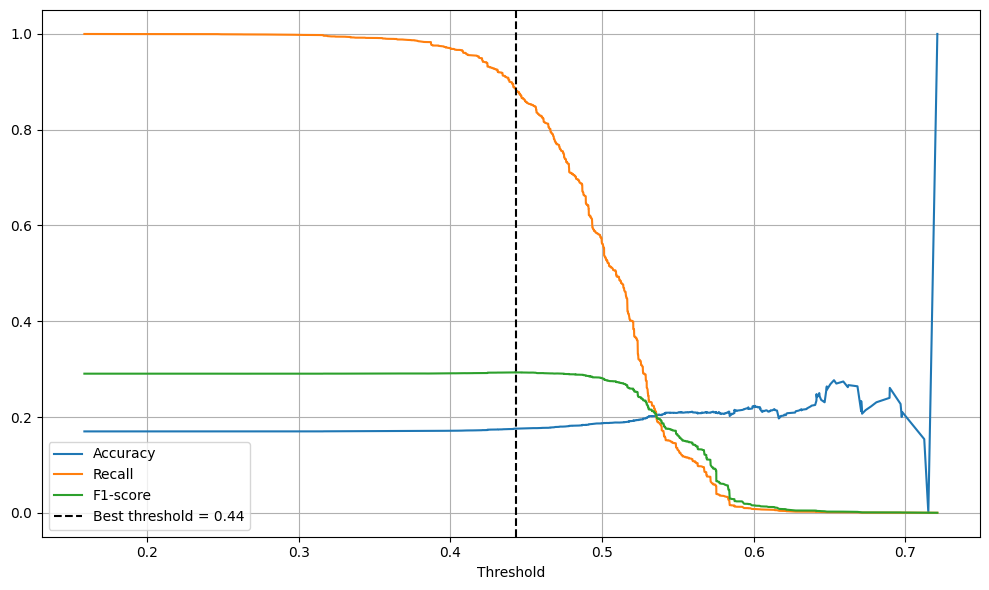

In [9]:
df_clean = df.dropna(subset=['IS_APPOINTMENT_SET']).copy()
df_clean['IS_APPOINTMENT_SET'] = df_clean['IS_APPOINTMENT_SET'].astype(int)

use_cols =  [
'IS_APPOINTMENT_SET', 
      'STATE', 'EMAIL_DOMAIN', 'OPERATINGSYSTEMCLASS','OPERATINGSYSTEMNAME',
                  'AGENTLANGUAGECODE', 'AGENTNAME','AGENTVERSIONMAJOR', 'DEVICEBRAND',
                 'DEVICEFIRMWAREVERSION', 'DEVICENAME' ,'DEVICEVERSION',
'FACEBOOKDEVICECLASS','LAYOUTENGINENAME','NETWORKTYPE',
'OPERATINGSYSTEMVERSIONMAJOR','WEBVIEWAPPNAME','MATCHLEVEL']
df_small = df_clean[use_cols].copy()


y = df_small['IS_APPOINTMENT_SET']
X = df_small.drop(columns=['IS_APPOINTMENT_SET'])


categorical_cols = [ 'STATE', 'EMAIL_DOMAIN', 'OPERATINGSYSTEMCLASS','OPERATINGSYSTEMNAME',
                  'AGENTLANGUAGECODE', 'AGENTNAME','AGENTVERSIONMAJOR', 'DEVICEBRAND',
                 'DEVICEFIRMWAREVERSION', 'DEVICENAME' ,'DEVICEVERSION',
'FACEBOOKDEVICECLASS','LAYOUTENGINENAME','NETWORKTYPE',
'OPERATINGSYSTEMVERSIONMAJOR','WEBVIEWAPPNAME','MATCHLEVEL']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42)
for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

model = LGBMClassifier(
    class_weight='balanced',
    n_estimators=200,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1
)

model.fit(
    X_train,
    y_train,
    categorical_feature=categorical_cols
)

y_proba = model.predict_proba(X_test)[:, 1]
y_pred_default = model.predict(X_test)

print("Using default threshold (0.5):")
print(classification_report(y_test, y_pred_default))
print("Confusion Matrix:", confusion_matrix(y_test, y_pred_default))
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
print(f"Best threshold for F1-score: {best_threshold:.3f}")
print(f"Best F1-score: {best_f1:.3f}")

y_pred_optimal = (y_proba >= best_threshold).astype(int)

print("Classification Report (best F1-Score):")
print(classification_report(y_test, y_pred_optimal))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_optimal))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[1:], label='Accuracy')
plt.plot(thresholds, recall[1:], label='Recall')
plt.plot(thresholds, f1_scores[1:], label='F1-score')
plt.axvline(x=best_threshold, color='black', linestyle='--', label=f'Best threshold = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
# f1_scorer = make_scorer(f1_score)
# param_grid = {
#     'n_estimators': [100, 200],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'num_leaves': [31, 50, 100],
#     'max_depth': [ -1, 10, 20],
#     }
# model = LGBMClassifier(
#     class_weight='balanced',
#     random_state=42,
#     n_jobs=-1)

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     scoring=f1_scorer,
#     cv=cv,
#     verbose=3,
#     n_jobs=-1
# )
# grid_search.fit(X_train, y_train, categorical_feature=categorical_cols)

# print(f"Best F1-score: {grid_search.best_score_:.4f}")
# print("Best params:")
# for param, value in grid_search.best_params_.items():
#     print(f"  {param}: {value}")


In [11]:
# from sklearn.model_selection import cross_val_score

# scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

# print("Accuracy по фолдам:", scores)
# print("Средняя accuracy:", scores.mean())

# Analysis column by column

In [12]:
use_cols =  [
    'IS_APPOINTMENT_SET',
    'STATE',
    'ZIP_CODE',
    'ATTRIBUTES_COREDEMOGRAPHICS_GENDER',
    'ATTRIBUTES_COREDEMOGRAPHICS_HOMEOWNERCD',
    'OPERATINGSYSTEMCLASS',
    'DEVICEBRAND',
    'NETWORKTYPE',
    'EMAIL_DOMAIN',

       'ATTRIBUTES_COREDEMOGRAPHICS_DOB', 
       'ATTRIBUTES_COREDEMOGRAPHICS_MARRIEDCD',
       'ATTRIBUTES_COREDEMOGRAPHICS_WEALTHSCR',
        'ATTRIBUTES_COREDEMOGRAPHICS_EHI',
    
    
    'ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_FIREPLCD',
    'ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_POOL',
    'ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_CREDITCARD',
    'ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_HHNBRSR',
    'ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_YRBLD',
    'ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_LOR',
    'ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_HHNBR',
    'ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_CENS_POP_DENSITY',
     'ATTRIBUTES_CONNEXSEGMENTATION_CT_HOMEIMPROVE12_ANY',
    'ATTRIBUTES_CONNEXSEGMENTATION_CT_HOMEREMODEL12_ANY',
    'ATTRIBUTES_CONNEXSEGMENTATION_CT_SOCIALUSAGE30_FB',
    'ATTRIBUTES_CONNEXSEGMENTATION_CT_SOCIALUSAGE30_INSTA',
    'ATTRIBUTES_CONNEXSEGMENTATION_CT_SOCIALUSAGE30_LNKIN',
    'ATTRIBUTES_CONNEXSEGMENTATION_CT_SOCIALUSAGE30_PINT',
    'ATTRIBUTES_CONNEXSEGMENTATION_CT_SOCIALUSAGE30_TWITTER',
    'ATTRIBUTES_CONNEXSEGMENTATION_CT_SOCIALUSAGE30_YOUTUBE',
    'ATTRIBUTES_CONNEXSEGMENTATION_CT_STRMSUB_HULU',
    'ATTRIBUTES_CONNEXSEGMENTATION_CT_STRMSUB_NETFLIX',
    'ATTRIBUTES_CONNEXSEGMENTATION_CT_ONLINESHOPSEG_DEALSEEK',
    'ATTRIBUTES_CONNEXSEGMENTATION_CT_ONLINESHOPSEG_OFFLINE',
    'ATTRIBUTES_CONNEXSEGMENTATION_CT_ONLINESHOPSEG_QUALSEEK',
    'ATTRIBUTES_CONNEXSEGMENTATION_CT_ONLINESHOPSEG_STRAITFWD',
    'ATTRIBUTES_CONNEXSEGMENTATION_CT_ONLINESHOPSEG_TRAD',
    'ATTRIBUTES_CONNEXSEGMENTATION_CT_MEDIA_HEAVYUSAGE_INTERNET',
    'ATTRIBUTES_CONNEXSEGMENTATION_CT_MEDIA_HEAVYUSAGE_MAGAZINE',
    'ATTRIBUTES_CONNEXSEGMENTATION_CT_MEDIA_HEAVYUSAGE_NEWSPAPER',
    'ATTRIBUTES_CONNEXSEGMENTATION_CT_MEDIA_HEAVYUSAGE_RADIO',
    'ATTRIBUTES_CONNEXSEGMENTATION_CT_MEDIA_HEAVYUSAGE_TV',
]

def show(col):
    print(f"Column name: {col}")
    print(df[col].unique())
    print(f"NaNs: {len(df[df[col].isna()])}")
    print(df[col].value_counts())
for col in use_cols:
    show(col)

Column name: IS_APPOINTMENT_SET
[True False nan]
NaNs: 3089
False    236323
True      48387
Name: IS_APPOINTMENT_SET, dtype: int64
Column name: STATE
[nan 'OH' 'TX']
NaNs: 219467
TX    36918
OH    31414
Name: STATE, dtype: int64
Column name: ZIP_CODE
[61080. 33914. 42055. ... 57078.  2824. 48628.]
NaNs: 3089
77449.0    412
37042.0    402
77494.0    347
77084.0    339
77373.0    322
          ... 
25260.0      1
33484.0      1
62682.0      1
24430.0      1
48628.0      1
Name: ZIP_CODE, Length: 18808, dtype: int64
Column name: ATTRIBUTES_COREDEMOGRAPHICS_GENDER
[nan 'M' 'F']
NaNs: 109055
F    92114
M    86630
Name: ATTRIBUTES_COREDEMOGRAPHICS_GENDER, dtype: int64
Column name: ATTRIBUTES_COREDEMOGRAPHICS_HOMEOWNERCD
[nan 'H' 'O' 'U' 'R' 'P']
NaNs: 149723
H    118461
O      9071
R      6195
U      2843
P      1506
Name: ATTRIBUTES_COREDEMOGRAPHICS_HOMEOWNERCD, dtype: int64
Column name: OPERATINGSYSTEMCLASS
['Mobile' 'Desktop' nan]
NaNs: 3107
Mobile     249647
Desktop     35045
Name: OPERA

NaNs: 250752
Y    37047
Name: ATTRIBUTES_CONNEXSEGMENTATION_CT_ONLINESHOPSEG_QUALSEEK, dtype: int64
Column name: ATTRIBUTES_CONNEXSEGMENTATION_CT_ONLINESHOPSEG_STRAITFWD
[nan 'Y']
NaNs: 254393
Y    33406
Name: ATTRIBUTES_CONNEXSEGMENTATION_CT_ONLINESHOPSEG_STRAITFWD, dtype: int64
Column name: ATTRIBUTES_CONNEXSEGMENTATION_CT_ONLINESHOPSEG_TRAD
[nan 'Y']
NaNs: 255707
Y    32092
Name: ATTRIBUTES_CONNEXSEGMENTATION_CT_ONLINESHOPSEG_TRAD, dtype: int64
Column name: ATTRIBUTES_CONNEXSEGMENTATION_CT_MEDIA_HEAVYUSAGE_INTERNET
[nan 'Y']
NaNs: 259592
Y    28207
Name: ATTRIBUTES_CONNEXSEGMENTATION_CT_MEDIA_HEAVYUSAGE_INTERNET, dtype: int64
Column name: ATTRIBUTES_CONNEXSEGMENTATION_CT_MEDIA_HEAVYUSAGE_MAGAZINE
[nan 'Y']
NaNs: 248867
Y    38932
Name: ATTRIBUTES_CONNEXSEGMENTATION_CT_MEDIA_HEAVYUSAGE_MAGAZINE, dtype: int64
Column name: ATTRIBUTES_CONNEXSEGMENTATION_CT_MEDIA_HEAVYUSAGE_NEWSPAPER
[nan 'Y']
NaNs: 264897
Y    22902
Name: ATTRIBUTES_CONNEXSEGMENTATION_CT_MEDIA_HEAVYUSAGE_NEWSPAPER, dtyp

In [13]:
total_rows = len(df)
filled_counts = df.notna().sum()
fill_percentage = (filled_counts / total_rows) * 100
fill_percentage = fill_percentage.round(2)

unique_counts = df.nunique(dropna=True)

summary_df = pd.DataFrame({
    'column': fill_percentage.index,
    'fill_%': fill_percentage.values,
    'n_unique': unique_counts.values
})
summary_df

,column,fill_%,n_unique
0,HASHED_PHONE_NUMBER,100.00,276269
1,IS_APPOINTMENT_SET,98.93,2
2,LEAD_CREATED_AT_UTC,98.93,282461
3,ZIP_CODE,98.93,18808
4,CITY,98.91,9739
...,...,...,...
79,Enchantress,98.91,100
80,Enigma,98.91,100
81,Faceless Void,98.91,49
82,Pudge,98.91,82


# USERS WITH MORE THAN 1 ITERATION

In [14]:
df1 = df[df['IS_APPOINTMENT_SET'].notna()]
duplicate_counts = df1['HASHED_PHONE_NUMBER'].value_counts()
duplicated_numbers = duplicate_counts[duplicate_counts > 1].index
df_duplicates_only = df1[df1['HASHED_PHONE_NUMBER'].isin(duplicated_numbers)]
df_duplicates_only['IS_APPOINTMENT_SET'] = df_duplicates_only['IS_APPOINTMENT_SET'].astype(int)
df_duplicates_only.groupby('HASHED_PHONE_NUMBER')['IS_APPOINTMENT_SET'].sum().sort_values(ascending=False).reset_index(drop=False)[:10]
df_duplicates_only.shape

C:\Users\Семён\AppData\Local\Temp\ipykernel_5916\2579887377.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_duplicates_only['IS_APPOINTMENT_SET'] = df_duplicates_only['IS_APPOINTMENT_SET'].astype(int)


(14547, 84)

In [15]:
df = df_duplicates_only.copy()
df['LEAD_CREATED_AT_UTC'] = pd.to_datetime(df['LEAD_CREATED_AT_UTC'])
df_sorted = df.sort_values(by=['HASHED_PHONE_NUMBER', 'LEAD_CREATED_AT_UTC'])
def assign_status_for_group(series):
    first_val = series.iloc[0]
    last_val = series.iloc[-1]
    unique_vals = set(series)

    if first_val == last_val:
        if len(unique_vals) > 1:
            return 'other'
        else:
            return f'all_{first_val}'
    else:
        if first_val == 1 and last_val == 0:
            return '1->0'
        elif first_val == 0 and last_val == 1:
            return '0->1'
        else:
            return 'other'
df_sorted['STATUS'] = df_sorted.groupby('HASHED_PHONE_NUMBER')['IS_APPOINTMENT_SET'].transform(assign_status_for_group)
df_sorted['STATUS'].value_counts()

all_0    10011
1->0      1619
0->1      1599
other      901
all_1      417
Name: STATUS, dtype: int64

In [16]:
"""
NEXT STEPS
OptionA :
    Markov's equatations
OptionB:
    Cox model
"""

"\nNEXT STEPS\nOptionA :\n    Markov's equatations\nOptionB:\n    Cox model\n"